# Consensus pattern


## 0. Setup

In [1]:
from dotenv import load_dotenv
import json
from pydantic import BaseModel, Field, confloat

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END

# Import the prebuilt agents
import finance.stock_research_agent as stock_research
import finance.industry_research_agent as industry_research
import finance.stock_trend_analyst as trend_analysis

from typing import List, Literal
from enum import Enum
from pydantic import BaseModel, Field

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# CHANGE THIS TO POINT TO YOUR OWN FILE
# Load the file that contains the API keys 
load_dotenv('C:\\Users\\raj\\.jupyter\\.env')

# You can change the index in llm creation calls to control which LLM is used by the agents
# NOTE: Some LLM like Llama may not produce structured output
models = [
            {"model":"gpt-4.1-mini", "model_provider":"openai"},
            {"model":"command-r",  "model_provider":"cohere"},
            {"model": "moonshotai/kimi-k2-instruct", "model_provider": "groq"},
            {"model":"claude-3-5-sonnet-latest", "model_provider":"anthropic"},
            {"model": "llama-3.3-70b-versatile", "model_provider": "groq"}
]

## 1. State schema

In [3]:
class DecisionEnum(str, Enum):
    BUY = "BUY"
    HOLD = "HOLD"
    SELL = "SELL"

class StockRecommendation(BaseModel):
    reasons: List[str] = Field([], description="Reasons to support the decision")
    decision: DecisionEnum = Field(None, description="Recommended action for the stock")
    confidence_score: confloat(ge=0, le=1) = Field(-1.0, description="Confidence in the recommendation")

# The subagents update the specific attributes in the shared state object
class StockConsensusState(BaseModel):
    stock_research_recommendation: StockRecommendation = Field("", description="Updated by stock research agent")
    industry_research_recommendation: StockRecommendation = Field("", description="Updated by industry research agent")
    stock_trends_research_recommendation: StockRecommendation = Field("", description="Updated by stocks trend research agent")
    
    ticker: str = Field("", description="Ticker symbol for the stock")
    report: str = Field("", description="Aggregated report on the stock")
    reasons: List[str] = Field([], description="Reasons to support the decision")
    decision: DecisionEnum = Field(None, description="Recommended action for the stock")
    confidence_score: confloat(ge=0, le=1) = Field(-1.0, description="Confidence in the recommendation")

## 2. Finance sub-agents nodes
**Note:** Python code for the agents is already provided under the subfolder *finance*

#### Stock research agent node

In [4]:
# Model used for the agents
chat_llm = init_chat_model(**models[0])

# Create & wrap stock research agent
stock_research_agent = stock_research.create_stock_research_agent(chat_llm)

def  stock_research_node(state: StockConsensusState)->dict:

    result = stock_research_agent.invoke({
        "messages": [HumanMessage(content=f"Analyze stock fundamentals and performance for {state.ticker}")]
    })

    recommendation =  result["structured_response"].model_dump(exclude={'report'})

    # print(type(recommendation))
    
    return {"stock_research_recommendation": recommendation}
    

# Unit testing
# state = StockConsensusState()
# state.ticker='AAPL'
# result = stock_research_node(state)
# print(result)


#### Industry research agent node

In [5]:
# Create and wrap industry research agent
industry_research_agent = industry_research.create_industry_research_agent(chat_llm)

def  industry_research_node(state: StockConsensusState)->dict:
    
    result = industry_research_agent.invoke({
        "messages": [HumanMessage(content=f"Analyze industry conditions and competitive position for {state.ticker}. Provide the desicion on whether to HOLD/SELL/BUY stock")]
    })

    recommendation =  result["structured_response"].model_dump(exclude={'report'})
    
    return {"industry_research_recommendation": recommendation}

# Unit testing
# state = StockConsensusState()
# state.ticker='AAPL'
# result = industry_research_node(state)
# print(result)


#### Stock trend analyst as node

In [6]:
stock_trend_analyst_agent = trend_analysis.create_stock_trend_analyst_agent(chat_llm)

def  stock_trend_analyst_node(state: StockConsensusState)->str:
    
    result = stock_trend_analyst_agent.invoke({
        "messages": [HumanMessage(content=f"Analyze technical and market trends for {state.ticker} and provide the decision on whether to BUY, HOLD, SELL stock")]
    })

    
    
    recommendation =  result["structured_response"].model_dump(exclude={'report', 'analysis'})

    # print(recommendation)
    
    return {"stock_trends_research_recommendation": recommendation}

# Unit testing
# state = StockConsensusState()
# state.ticker='AMZN'
# result = stock_trend_analyst_node(state)
# print(result)

## 3. Consensus agent
This agent looks through the analysis from the 3 sub-agents and make a final decision by analyzing the reason, decision & confidence score

In [7]:

CONSENSUS_PROMPT = """
                    You are a STOCK RESEARCH EXPERT.
                    
                    You will be given three independent research reports created by 3 experts:
                    - stock_research (company fundamentals & performance)
                    - industry_research (sector and competitive context)
                    - stock_trends_research (market and technical signals)
                    
                    The 3 reports you will receive have the following structure:
                    
                    {{
                      "reasons": string[],  # Reasons the expert made the recommendation to SELL/HOLD/BUY
                      "decision": "BUY" | "HOLD" | "SELL",  # Must be exactly one of these literal values
                      "confidence_score": number (0.0 to 1.0)  # Confidence of the expert in their recommendation
                    }}
                    
                    Ticker: {ticker}
                    
                    ------------------------------------
                    RESEARCH INPUTS
                    ------------------------------------
                    
                    [Stock Research]
                    {stock_research_recommendation}
                    
                    [Industry Research]
                    {industry_research_recommendation}
                    
                    [Stock Trends Research]
                    {stock_trends_research_recommendation}
                    
                    ------------------------------------
                    YOUR TASK
                    ------------------------------------
                    
                    Synthesize the three research inputs into a final recommendation for this stock.
                    
                    You must:
                    1. Carefully review the research shared by the experts
                    2. Consider each expert’s reasons, decision, and confidence score
                    3. Write a concise, executive-level report summarizing your analysis
                    4. Extract the most important reasons supporting your final view
                    5. Choose exactly ONE recommendation: BUY, HOLD, or SELL (uppercase, no extra spaces)
                    6. Assign a confidence score between 0.0 and 1.0 for your recommendation
                    
                    ------------------------------------
                    STRICT RULES
                    ------------------------------------
                    
                    - Use ONLY the provided research; do NOT invent financial facts
                    - Resolve conflicts explicitly; weigh downside risks more heavily than weak upside signals
                    - Avoid generic language
                    - Do NOT output anything other than the structured response
                    
                    ------------------------------------
                    OUTPUT REQUIREMENTS
                    ------------------------------------
                    
                    Your response MUST be a single JSON object with exactly these fields:
                    
                    {{
                      "report": string,      # Executive report explaining your final recommendation
                      "reasons": string[],   # Key reasons supporting your recommendation
                      "decision": "BUY" | "HOLD" | "SELL",  # Mandatory, exactly one value
                      "confidence": float    # Number between 0.0 and 1.0
                    }}
                    
                    Even if unsure, you MUST choose one of BUY, HOLD, or SELL. Think like an investment committee chair delivering the final call.
                    """

# Create the agent
# Note: there are no tools provided to the agents
consensus_agent = create_react_agent(
    model=init_chat_model(**models[0]),
    tools=[],  # no tools — pure synthesis
    name="stock_aggregator_agent",
    prompt=CONSENSUS_PROMPT,
    response_format=StockConsensusState
)


## 4. Consensus node

In [8]:
def consensus_node(state: StockConsensusState):

    prompt = CONSENSUS_PROMPT.format(
        stock_research_recommendation=state.stock_research_recommendation,
        industry_research_recommendation=state.industry_research_recommendation,
        stock_trends_research_recommendation=state.stock_trends_research_recommendation,
        ticker=state.ticker
    )

    response = consensus_agent.invoke({
        "messages": [HumanMessage(content=prompt)]
    })

    content = response["messages"][-1].content

    result = json.loads(content) 


    return {
        "report": result.get("report", ""),
        "reasons": result.get("reasons", []),
        "decision": result.get("decision", None),
        "confidence": result.get("confidence", -1.0),
    }

## 5. Create the Graph with consensus


https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#2-create-supervisor-with-langgraph-supervisor

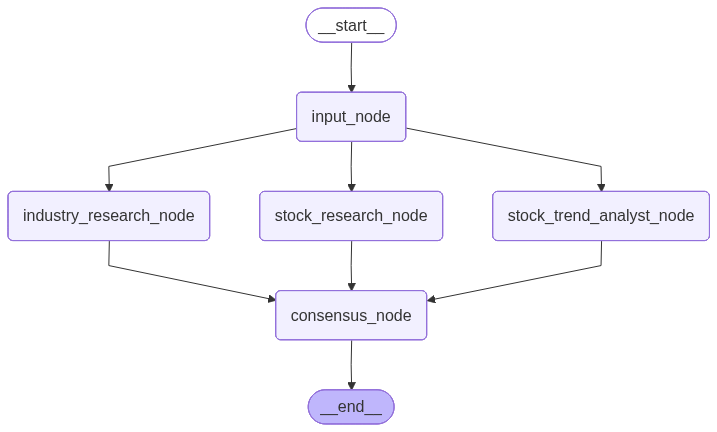

In [9]:

# For future pre-processing
def input_node(StockConsensusState):
    # pass
    return {}
    

graph = StateGraph(StockConsensusState)

graph.add_node("input_node", input_node)
graph.add_node("stock_research_node", stock_research_node)
graph.add_node("industry_research_node", industry_research_node)
graph.add_node("stock_trend_analyst_node", stock_trend_analyst_node)
graph.add_node("consensus_node", consensus_node)

# Entry point
graph.set_entry_point("input_node")

# ---- fan-out (parallel research) ----
graph.add_edge("input_node", "stock_research_node")
graph.add_edge("input_node", "industry_research_node")
graph.add_edge("input_node", "stock_trend_analyst_node")

# ---- fan-in (aggregation) ----
graph.add_edge("stock_research_node", "consensus_node")
graph.add_edge("industry_research_node", "consensus_node")
graph.add_edge("stock_trend_analyst_node", "consensus_node")

# End
graph.add_edge("consensus_node", END)

stock_research_app = graph.compile()

stock_research_app


# 6.Test the agent

In [17]:
# Try : GTM, TSLA, ZGN, 
input = { "ticker": "ONDS"}

response  = stock_research_app.invoke(input)

# Print the rport
print("Recommendation for ", response["ticker"])
print("=======================")
print(response["decision"])

print("\nExecutive report")
print("================")
print(response["report"])

print("\nReasons")
print("=======")
print("\n".join(response["reasons"]))



Recommendation for  ONDS
HOLD

Executive report
Ondas demonstrates strong fundamental growth potential, highlighted by significant upward revisions in 2025 and 2026 revenue guidance driven by its autonomous systems segment and acquisition-driven growth. The stock’s recent substantial rally reflects this momentum. However, industry analysis points to competitive pressures and inherent financial and operational risks, warranting a more cautious outlook. Technical signals show a strong long-term uptrend but indicate short-term resistance and consolidation, with increased selling pressure near recent highs creating uncertainty about immediate direction. Balancing these factors, the downside risks and market caution outweigh the strong fundamental growth, leading to a HOLD recommendation with moderate confidence.

Reasons
Raised 2025 and 2026 revenue guidance driven by autonomous systems and acquisitions
Strong past stock price appreciation indicating growth expectations priced in
Industry 

In [16]:
response

{'stock_research_recommendation': {'reasons': ['2025 revenue guidance raised to $47.6M-$49.6M, 23% above prior targets and consensus.',
   '2026 revenue outlook increased to $170M-$180M, a 25% raise reflecting strong expected growth.',
   'Acquisition of Roboteam for $80M bolsters expansion into autonomous systems.',
   'Stock price has surged nearly 600% in six months, reflecting strong investor confidence.',
   'Despite soaring costs and elevated valuation, company fundamentals remain solid with anticipated demand growth.'],
  'decision': <DecisionEnum.BUY: 'BUY'>,
  'confidence_score': 0.85},
 'industry_research_recommendation': {'decision': <DecisionEnum.HOLD: 'HOLD'>,
  'reasons': ['Industry is growing with increasing e-commerce SaaS adoption.',
   'ONDS shows strong revenue growth indicating market acceptance.',
   'Faces intense competition from larger SaaS providers.',
   'Heavy investments are limiting near-term profits.',
   'Economic uncertainties may affect customer IT spen